Universidad del valle de Guatemala <br>
Facultad de Ingeniería <br>
Departamento de ciencias de la Computación <br>
Inteligencia Artificial <br>

Grupo # 9 <br><br>
Christopher García 20541 <br>
Gabriel Vicente 20491 <br>
Maria Isabel Solano 20504 <br>

### Laboratorio 8: Mixture Models y Segmentación de Clientes de Banco
Deberá construir un modelo basado en aprendizaje no supervisado para el dataset dado. Lo que se busca con este
modelo es poder segmentar a clientes de una entidad bancaria para poder así tomar decisiones a nivel comercial y
potenciar las operaciones de la empresa

### Task 1.1

In [208]:
import pandas as pd # Import Pandas for data manipulation using dataframes
import numpy as np # Import Numpy for data statistical analysis 
import matplotlib.pyplot as plt # Import matplotlib for data visualisation
import seaborn as sns # Statistical data visualization
from sklearn.metrics import silhouette_score
from quickda.clean_data import *
from sklearn.mixture import GaussianMixture

# Leer archivo csv
df = pd.read_csv('bank_transactions.csv' , low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [209]:
columns_to_drop = ["TransactionDate", "CustomerDOB", "CustomerID", "TransactionID", "TransactionDate", "TransactionTime"]
df = clean(df, method = 'dropcols', columns = columns_to_drop)

In [210]:
# Eliminar filas con valores NaN
df = df.dropna()

# Codificando variables categoricas

# Genero
df['CustGender'] = df['CustGender'].replace({'M': 0, 'F': 1, 'T': 2})

# Ubicacion

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['CustLocation'] = le.fit_transform(df['CustLocation'])

In [211]:
#Implementación aquí


In [212]:
df.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR)
0,1,3567,17819.05,25.0
1,0,3629,2270.69,27999.0
2,1,5242,17874.44,459.0
3,1,5242,866503.21,2060.0
4,1,5631,6714.43,1762.5


### Arreglo de datos

In [213]:
import pandas as pd
import numpy as np

# Seleccionar características relevantes
X = df[['CustAccountBalance', 'TransactionAmount (INR)']].values

# Normalizar características
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [214]:
from random import *
seed(100)
k = choices(range(0, X.shape[0]), k = 10000)
X_copy = np.array([X[val] for val in k])
X = X_copy
print(X.shape)

(10000, 2)


### Implementación sin librerías
basado en https://towardsdatascience.com/gaussian-mixture-models-implemented-from-scratch-1857e40ea566

In [215]:
class GausianMixture:
    def __init__(self, n_components, max_iter = 100, nombres_comp = None):
        self.n_comp = n_components
        self.max_iter = max_iter
        
        if nombres_comp == None:
            # Agregamos los ínices como nombre
            self.nombres_comp = [f"comp{index}" for index in range(self.n_comp)]
            
        else:
            self.nombres_comp = nombres_comp
            
        # La lista pi contiene la fracción de datos por cada cluster
        self.pi = [1/self.n_comp for comp in range(self.n_comp)]
        
    def fit(self, X):
        # Separación de la data en subgrupos
        X_nuevo = np.array_split(X, self.n_comp)
        
        # Computación inicial del mean-vector y la matriz de covalencia
        self.mean_vector = [np.mean(x, axis = 0) for x in X_nuevo]
        self.matriz_cov = [np.cov(x.T) for x in X_nuevo]
        
        # Eliminar la nueva X
        del X_nuevo
        
        # Algoritmo EM
        for iteracion in range(self.max_iter):
            # E-step ---
            self.r = np.zeros((len(X), self.n_comp))
            
            # calcular matriz r
            for n in range(len(X)):
                for k in range(self.n_comp):
                    self.r[n][k] = self.pi[k] * self.normal_multivariable(X[n], self.mean_vector[k], self.matriz_cov[k])
                    self.r[n][k] /= sum([self.pi[j]*self.normal_multivariable(X[n], self.mean_vector[j], self.matriz_cov[j]) for j in range(self.n_comp)])
                    
            # Calcular n
            N = np.sum(self.r, axis= 0)
                    
                    
            # M-step ---
            self.mean_vector = np.zeros((self.n_comp, len(X[0])))
            
            # update en el mean_vector
            for k in range(self.n_comp):
                for n in range(len(X)):
                    self.mean_vector[k] += self.r[n][k] * X[n]
                self.mean_vector[k] = 1/N[k] * self.mean_vector[k]

                    
            # Iniciar matriz de covarianza
            self.matriz_cov = [np.zeros((len(X[0]), len(X[0]))) for k in range(self.n_comp)]
            
            # Actualizar matriz
            for k in range(self.n_comp):
                self.matriz_cov[k] = np.zeros((len(X[0]), len(X[0])))
                for n in range(len(X)):
                    self.matriz_cov[k] += self.r[n][k] * np.outer(X[n] - self.mean_vector[k], X[n] - self.mean_vector[k])
                self.matriz_cov[k] = 1/N[k] * self.matriz_cov[k]

            
            # Actualizar pi
            self.pi = [N[k]/len(X) for k in range(self.n_comp)]
            
                    
    def normal_multivariable(self, X, mean_vector, matriz_cov):
        return (2*np.pi)**(-len(X)/2)*np.linalg.det(matriz_cov)**(-1/2)*np.exp(-np.dot(np.dot((X - mean_vector).T, np.linalg.inv(matriz_cov)), (X - mean_vector))/2)
        
    def predict(self, X):
        probas = []
        for n in range(len(X)):
            probas.append([self.normal_multivariable(X[n], self.mean_vector[k], self.matriz_cov) for k in range(self.n_comp)])

        cluster = []
        for proba in probas:
            cluster.append(self.nombres_comp[np.argmax(proba)])
        return cluster

In [216]:
model = GaussianMixture(n_components= 3)
model.fit(X)
print()

In [217]:
# Predecir etiquetas de cluster
pred_y = model.predict(X)

print(pred_y)

[2 0 0 ... 0 0 0]


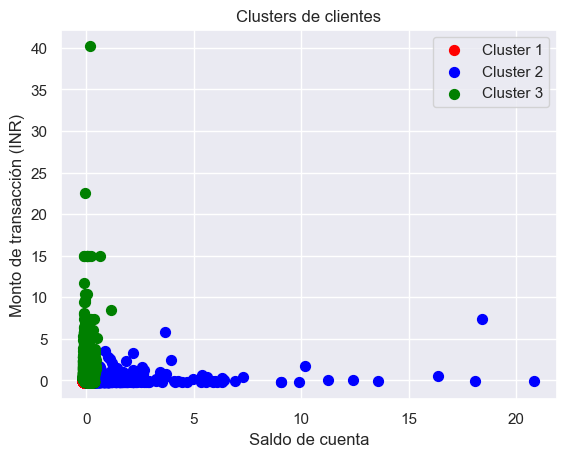

In [218]:
# Graficar clusters
plt.scatter(X[pred_y == 0, 0], X[pred_y == 0, 1], s=50, c='red', label='Cluster 1')
plt.scatter(X[pred_y == 1, 0], X[pred_y == 1, 1], s=50, c='blue', label='Cluster 2')
plt.scatter(X[pred_y == 2, 0], X[pred_y == 2, 1], s=50, c='green', label='Cluster 3')

# Graficar centroides
# plt.scatter(model.mean_vector[:, 0], mean_vector[:, 1], s=100, c='black', label='Centroides')

plt.title('Clusters de clientes')
plt.xlabel('Saldo de cuenta')
plt.ylabel('Monto de transacción (INR)')
plt.legend()
plt.show()

### Comparación con librerías

In [219]:
# Ajustar modelo GMM
gmm = GaussianMixture(n_components=3)
gmm.fit(X)

# Predecir etiquetas de cluster
pred_y_sk = gmm.predict(X)

print(pred_y_sk)

[1 2 2 ... 2 2 2]


Puntaje de silueta: 0.5213089536259942


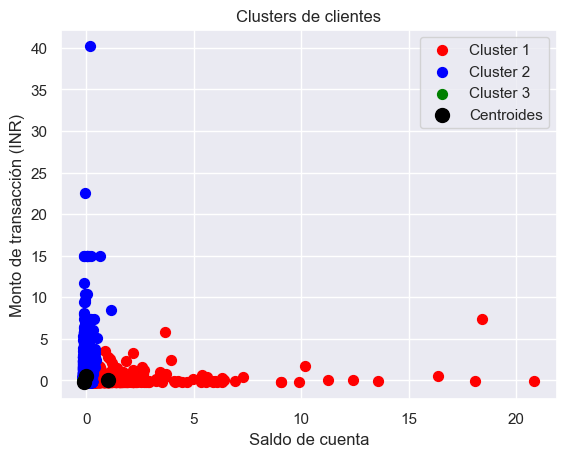

In [220]:


# Calcular puntaje de silueta
silhouette_avg = silhouette_score(X, pred_y_sk)
print("Puntaje de silueta:", silhouette_avg)

# Graficar clusters
plt.scatter(X[pred_y_sk == 0, 0], X[pred_y_sk == 0, 1], s=50, c='red', label='Cluster 1')
plt.scatter(X[pred_y_sk == 1, 0], X[pred_y_sk == 1, 1], s=50, c='blue', label='Cluster 2')
plt.scatter(X[pred_y_sk == 2, 0], X[pred_y_sk == 2, 1], s=50, c='green', label='Cluster 3')

# Graficar centroides
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=100, c='black', label='Centroides')

plt.title('Clusters de clientes')
plt.xlabel('Saldo de cuenta')
plt.ylabel('Monto de transacción (INR)')
plt.legend()
plt.show()

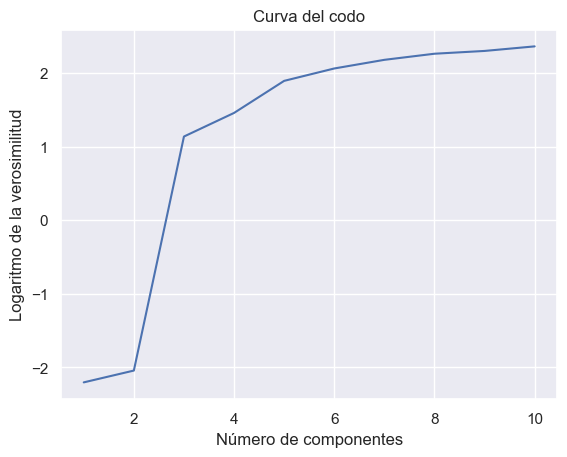

In [222]:
from sklearn.mixture import GaussianMixture

# Calcular logaritmo de verosimilitud para diferentes valores de n_components
log_likelihoods = []
for n_components in range(1, 11):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    gmm.fit(X)
    log_likelihood = gmm.score(X)
    log_likelihoods.append(log_likelihood)

# Graficar curva del codo
plt.plot(range(1, 11), log_likelihoods)
plt.title('Curva del codo')
plt.xlabel('Número de componentes')
plt.ylabel('Logaritmo de la verosimilitud')
plt.show()

Score de la silueta: 0.5351349442858817


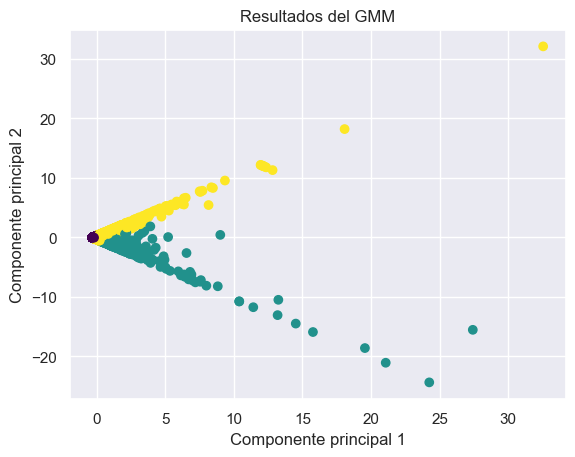

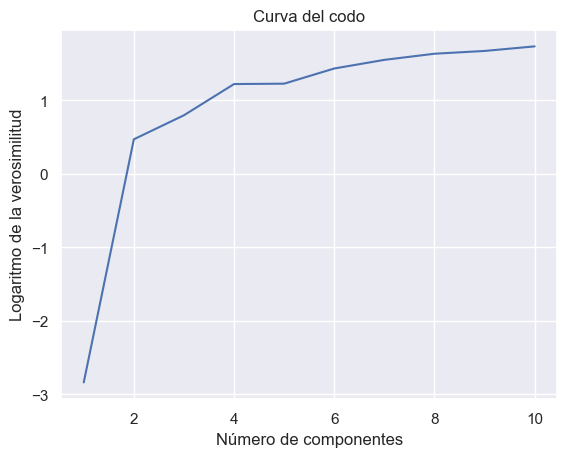

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# normalizar los datos
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# crear una instancia de PCA y ajustarla a los datos
pca = PCA(n_components=2)
pca.fit(X_norm)

# transformar los datos con PCA
X_pca = pca.transform(X_norm)

# crear una instancia de GMM y ajustarla a los datos
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
gmm.fit(X_pca)

# asignar cada punto a su cluster correspondiente
y_gmm = gmm.predict(X_pca)

# calcular el score de la silueta
silhouette_avg = silhouette_score(X_pca, y_gmm)
print("Score de la silueta:", silhouette_avg)

# graficar los resultados del GMM
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_gmm, cmap='viridis')
plt.title('Resultados del GMM')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.show()

# calcular logaritmo de verosimilitud para diferentes valores de n_components
log_likelihoods = []
for n_components in range(1, 11):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    gmm.fit(X_pca)
    log_likelihood = gmm.score(X_pca)
    log_likelihoods.append(log_likelihood)

# graficar curva del codo
plt.plot(range(1, 11), log_likelihoods)
plt.title('Curva del codo')
plt.xlabel('Número de componentes')
plt.ylabel('Logaritmo de la verosimilitud')
plt.show()


### Conclusiones